In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from predictor import Predictor
from reshaper import Reshaper
from reshaper import save_obj
from loader import Loader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.load("base_data/control_points.npz").files

['altura_cintura',
 'altura_virilha',
 'braço',
 'cintura',
 'comp_braço',
 'coxa',
 'ombro_a_ombro',
 'panturrilha',
 'peito',
 'pescoço',
 'pescoço_ao_quadril',
 'pulso',
 'quadril']

In [3]:
semantic = {
    "Weight": 0, # peso
    "Height": 1, # altura
    "WAIST_HT": 2,  # 'altura_cintura'
    "CROTCH_HT": 3,  # 'altura_virilha'
    "UP_ARM_GTH_L": 4,  # 'braço'
    "WAIST_GTH": 5,  # 'cintura'
    "ARM_LTH_L": 6,  # 'comp_braço'
    "THIGH_GTH_L_HZ": 7,  # 'coxa'
    "CR_SHOULDER": 8,  # 'ombro_a_ombro'
    "CALF_GTH_L": 9,  # 'panturrilha'
    "BUST_CHEST_GTH": 10,  # 'peito'
    "MID_NECK_GTH": 11,  # 'pescoço'
    "DIST_NECK_T_HIP": 12,  # 'pescoço_ao_quadril'
    "WRIST_GTH": 13,  # 'pulso'
    "HIP_GTH": 14,  # 'quadril'
    "Age": 15
}

# Select life colums

In [4]:
life_data = pd.read_csv("base_data/life_body_measure.csv", delimiter=",", decimal=",")
life_data.dropna(inplace=True)
life_data = life_data[life_data["Gender"] == "male"]

In [5]:
life_data = life_data[semantic.keys()]
life_data.reset_index(drop=True, inplace=True)

In [6]:
np.save("processed_data/male_life_selected.npy", np.array(life_data))

# Predict age

In [7]:
life_data_without_age = life_data.drop("Age", axis=1).to_numpy()
with np.load("./processed_data/male_measure.npz", allow_pickle=True) as file_data:
    measure, _, _, _ = file_data.values()
    measure /= 10
    measure[0] = ((measure[0]/100)**3)

In [8]:
distance = cdist(measure.T, life_data_without_age)
minid = np.argmin(distance, axis=1)
ages = life_data.loc[minid]["Age"].to_numpy()
measure_with_age = np.column_stack((measure.T, ages))

In [9]:
np.save("processed_data/male_measures_with_age.npy", measure_with_age)

# Correlation analysis

In [10]:
dataset = pd.read_csv("base_data/life_body_measure.csv", sep=",", decimal=",")
dataset = dataset.drop(["WTH_THIGH_SUM"], axis=1)

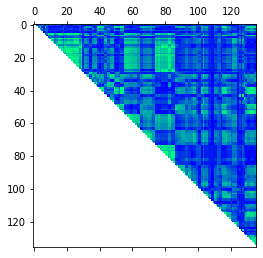

In [11]:
correlation_matrix = dataset.corr(method='pearson')
correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
correlation_matrix.to_pickle("correlation.pkl")
plt.matshow(correlation_matrix.abs(), cmap="winter")

In [12]:
age_correlation_data = correlation_matrix.loc["Age"].abs().sort_values(ascending=False)

In [13]:
exclude_list = ["WAIST_BUTTOCK_HT_R", 'IN_LEG_ANKLE_R', "SIDESEAM_3D_WD_R", "INSEAM_R", "WB_BUTTOCK_HT_R", "SIDESEAM_R", "SIDESEAM_ANKLE_R", "SIDE_UP_TORSO_LTH_R", "SIDESEAM_WAIST_R",
               "THIGH_GTH_R_HZ", "ARM_LTH_R", "FOREARM_LTH_R", "SHOULDER_ANGLE_R", "UP_ARM_LTH_R", "KNEE_GTH_R", "ARM_LTH_T_NECK_R","ANKLE_GTH_R", "ARM_LTH_T_NECK_B_R", "SHOULDER_WTH_R",
               "UP_ARM_DIAM_R", "CALF_GTH_R", "WTH_THIGH_R", "ELBOW_GTH_R", "NECK_R_T_WAIST_B", "UP_ARM_GTH_R", "FOREARM_GTH_R", "Age", "Record Number"]
age_correlation_data = age_correlation_data[~age_correlation_data.index.isin(exclude_list)]

In [14]:
# pd.set_option('display.max_rows', 10)
age_correlation_data

WAIST_T_BUTTOCK         0.510945
WHtR                    0.488762
WAIST_BUTTOCK_HT_L      0.486497
WAIST_T_HIGH_HIP_B      0.477425
ABSI                    0.474412
                          ...   
MIN_LEG_GTH_R           0.020122
TOT_TORSO_GTH           0.016676
UP_ARM_GTH_L            0.014253
DIST_CROTCH_WAISTBAN    0.013779
NECK_WAIST_C_BACK       0.005996
Name: Age, Length: 108, dtype: float64

In [15]:
r = (1.0,0.0,0.0)
g = (0.0,0.8,0.0)
b = (0.0,0.0,1.0)
colors = []
for metric in age_correlation_data.index:
    if metric in list(semantic.keys()):
        colors.append(r)
    elif metric in ["WHtR", "ABSI", "WHR"]:
        colors.append(g)
    else:
        colors.append(b)
# colors = [ r if metric in list(semantic.keys()) else b for metric in age_correlation_data.index]


<AxesSubplot:>

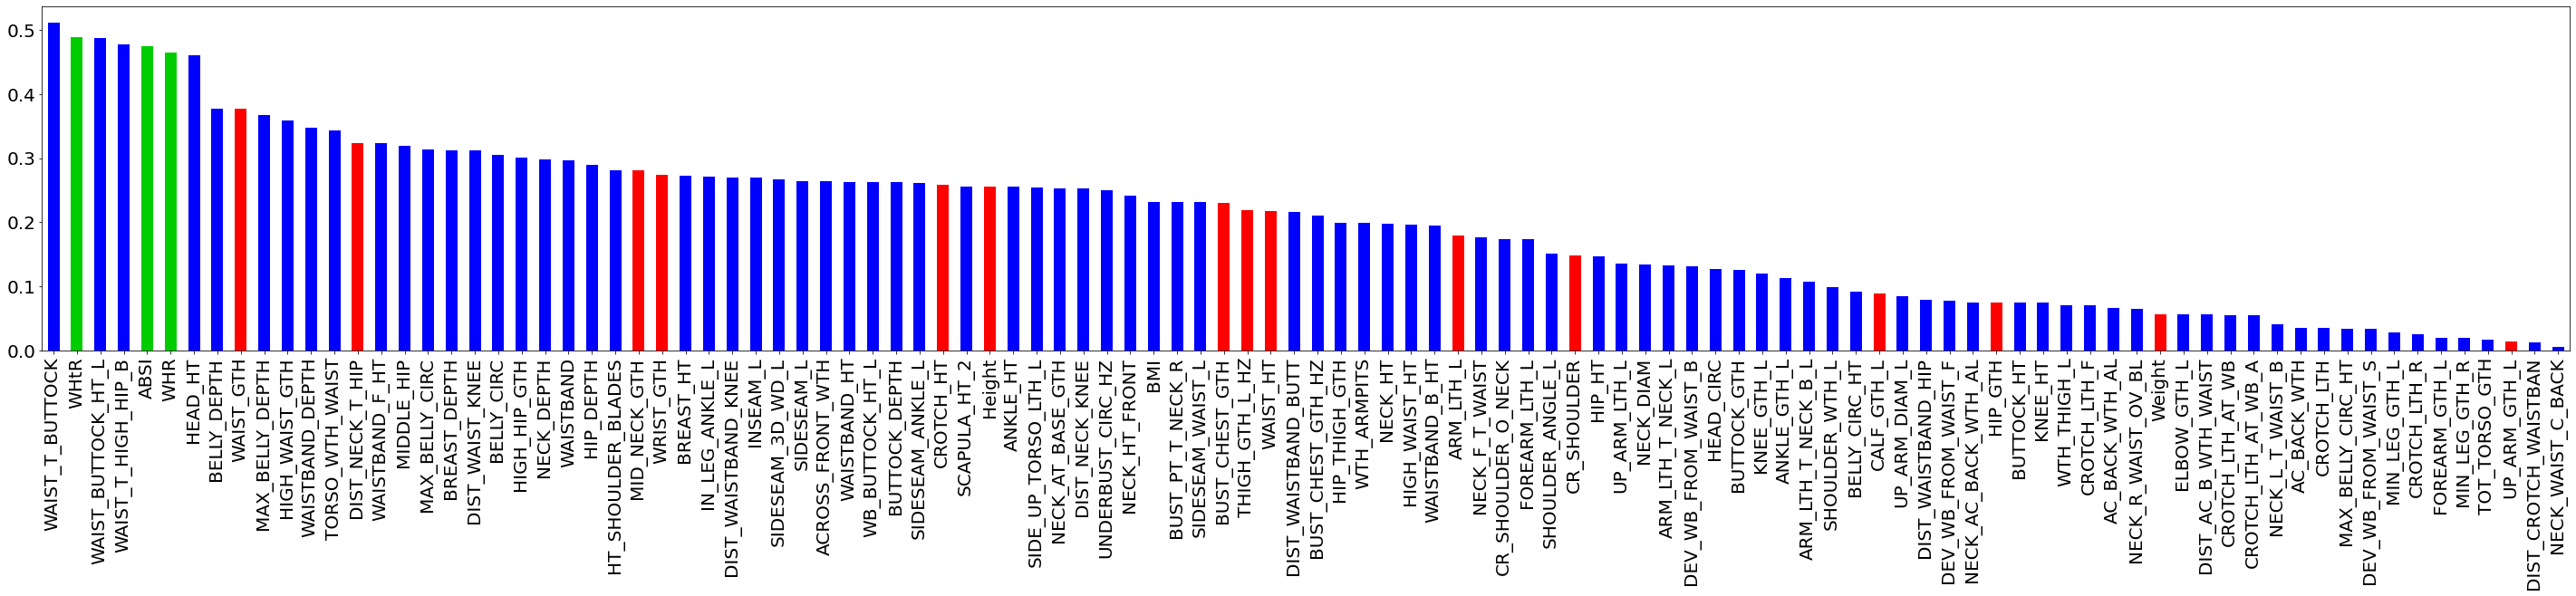

In [16]:
age_correlation_data.plot(kind="bar", figsize=(50,7), color=colors, fontsize=20)

In [17]:
minor_correlation = pd.concat([correlation_matrix.abs().idxmax(), correlation_matrix.abs().max()], axis=1)
minor_correlation = minor_correlation.reset_index(level=0)
minor_correlation.columns = ["from", "to", "corr"]
minor_correlation.sort_values(by="corr",ascending=False)

,from,to,corr
35,CROTCH_LTH_AT_WB_A,CROTCH_LTH_AT_WB,1.000000
20,KNEE_HT,BUTTOCK_HT,0.999943
25,SCAPULA_HT_2,Height,0.999929
81,SIDESEAM_3D_WD_R,SIDESEAM_R,0.999816
22,BELLY_CIRC_HT,BUTTOCK_HT,0.999079
...,...,...,...
1,Age,Record Number,0.454797
108,SHOULDER_ANGLE_L,SIDE_UP_TORSO_LTH_L,0.348551
126,DIST_WAISTBAND_HIP,DEV_WB_FROM_WAIST_S,0.233677
2,BMI,Age,0.231501


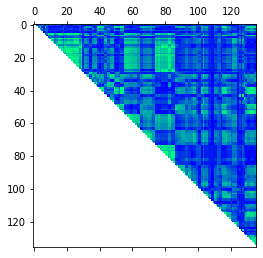

In [18]:
plt.matshow(correlation_matrix.abs(), cmap="winter")

In [19]:
correlation_matrix.to_pickle("correlation.pkl")

# Raw data analysis

In [20]:
data = np.full(16, np.nan)
data[0] = 95
data[1] = 185
data[-1] = 19
pred = Predictor(data)

In [21]:
over_time = []
for i in np.arange(19,81):
    over_time.append(np.append(pred.predict_next(denormalize=True), i))

In [22]:
data = pd.read_csv("base_data/life_body_measure.csv", delimiter=",", decimal=",")
data = data[semantic.keys()]
data = pd.DataFrame(data.to_numpy())

In [23]:
over_time_better = []
over_time_errors = []

for element in over_time:
    temp_data = data.copy()
    age = element[-1]
    temp_data = temp_data[temp_data[15] == age]
    
    if temp_data.empty:
        over_time_errors.append(np.nan)
        over_time_better.append(np.full(16,np.nan))
    else:
        error = np.sqrt(((temp_data - element)**2).sum(axis=1))
        error.reset_index(drop=True, inplace=True)
        better = np.argmin(error)
        over_time_errors.append(error.iloc[better])
        over_time_better.append(temp_data.iloc[better])

In [24]:
over_time_plot = np.array(over_time)
over_time_better_plot = np.array(over_time_better)
over_time_errors_plot = np.array(over_time_errors)
age_to_plot = over_time_plot[:,-1]

Text(0.5, 0, 'Age')

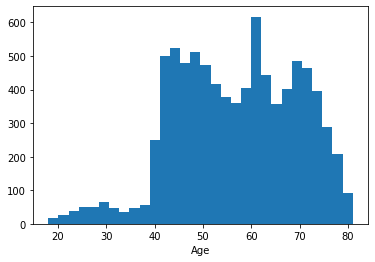

In [25]:
fig, ax = plt.subplots(1, 1)
ax.hist(data[15], bins=30)
ax.set_xlabel('Age')

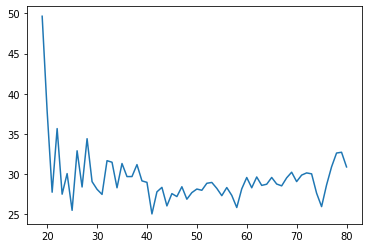

In [26]:
plt.plot(age_to_plot, over_time_errors_plot)

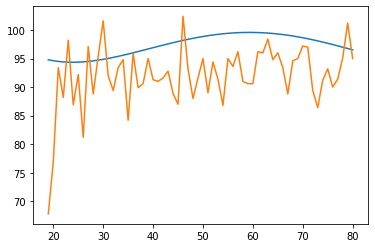

In [27]:
plt.plot(age_to_plot, over_time_plot[:,0])
plt.plot(age_to_plot, over_time_better_plot[:,0])

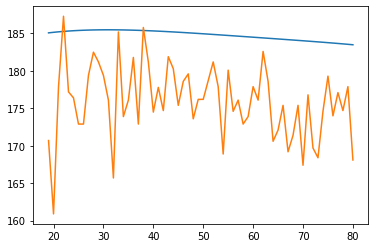

In [28]:
plt.plot(age_to_plot, over_time_plot[:,1])
plt.plot(age_to_plot, over_time_better_plot[:,1])

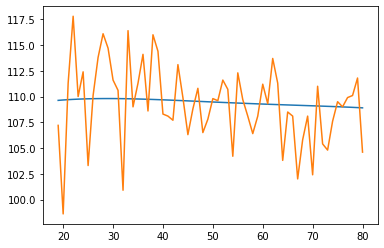

In [29]:
plt.plot(age_to_plot, over_time_plot[:,2]+20)
plt.plot(age_to_plot, over_time_better_plot[:,2])

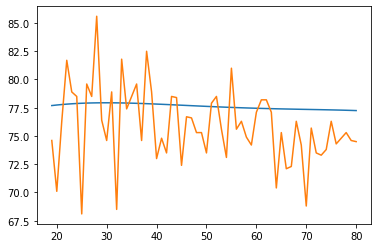

In [30]:
plt.plot(age_to_plot, over_time_plot[:,3])
plt.plot(age_to_plot, over_time_better_plot[:,3])

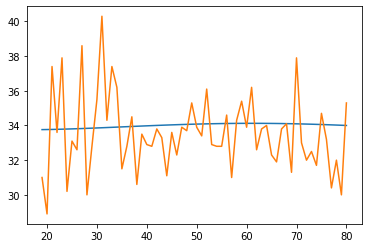

In [31]:
plt.plot(age_to_plot, over_time_plot[:,4]-4)
plt.plot(age_to_plot, over_time_better_plot[:,4])

[]

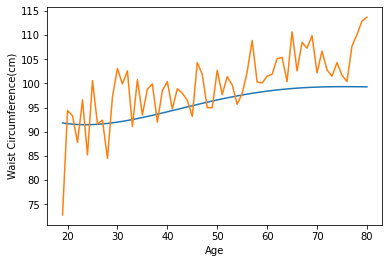

In [32]:
fig, ax = plt.subplots(1, 1)
ax.plot(age_to_plot, over_time_plot[:,5])
ax.plot(age_to_plot, over_time_better_plot[:,5])
ax.set_xlabel('Age')
ax.set_ylabel('Waist Circumference(cm)')
ax.plot()

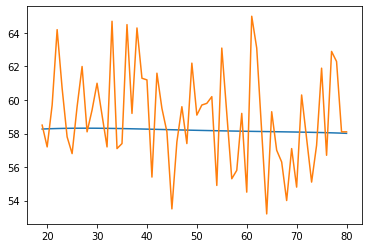

In [33]:
plt.plot(age_to_plot, over_time_plot[:,6])
plt.plot(age_to_plot, over_time_better_plot[:,6])

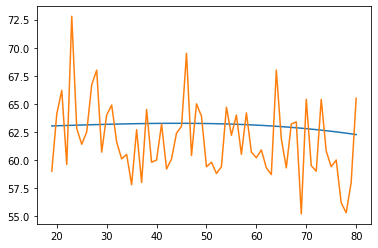

In [34]:
plt.plot(age_to_plot, over_time_plot[:,7]-5)
plt.plot(age_to_plot, over_time_better_plot[:,7])

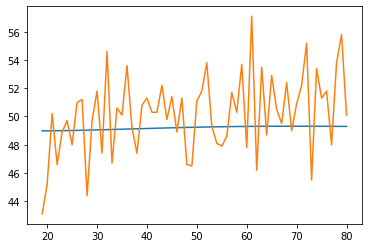

In [35]:
plt.plot(age_to_plot, over_time_plot[:,8]+1)
plt.plot(age_to_plot, over_time_better_plot[:,8])

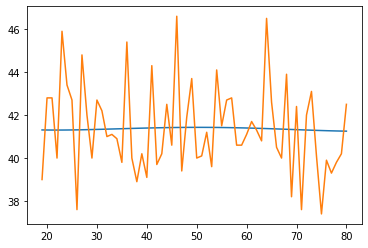

In [36]:
plt.plot(age_to_plot, over_time_plot[:,9]-3)
plt.plot(age_to_plot, over_time_better_plot[:,9])

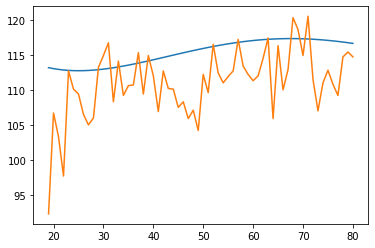

In [37]:
plt.plot(age_to_plot, over_time_plot[:,10])
plt.plot(age_to_plot, over_time_better_plot[:,10])

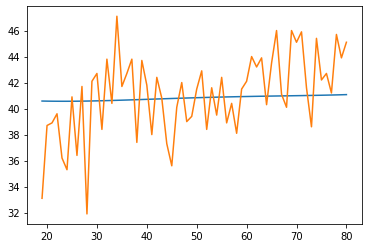

In [38]:
plt.plot(age_to_plot, over_time_plot[:,11])
plt.plot(age_to_plot, over_time_better_plot[:,11])

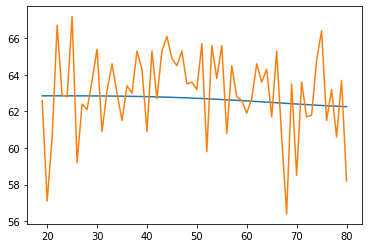

In [39]:
plt.plot(age_to_plot, over_time_plot[:,12]-9)
plt.plot(age_to_plot, over_time_better_plot[:,12])

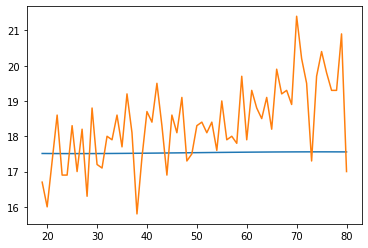

In [40]:
plt.plot(age_to_plot, over_time_plot[:,13])
plt.plot(age_to_plot, over_time_better_plot[:,13])

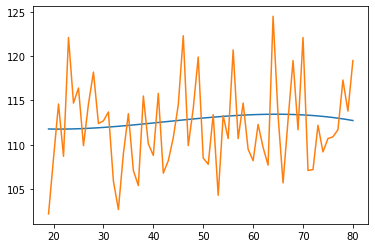

In [41]:
plt.plot(age_to_plot, over_time_plot[:,14])
plt.plot(age_to_plot, over_time_better_plot[:,14])

# 3D body analysis

In [72]:
import numpy as np
import pandas as pd

In [101]:
data = pd.read_csv("base_data/life_body_measure.csv", delimiter=",", decimal=",")
data = data[data.Gender == "female"]
data = data[semantic.keys()]
data = pd.DataFrame(data.to_numpy())

In [109]:
female = [(153, 35), (153, 50), (153, 65), (162, 40), (162, 55), (162, 70), (171, 45), (171, 60), (171, 75)]
femalet = ["153cm - 35", "153cm - 50kg", "153cm - 65kg", "162cm - 40kg", "162cm - 55kg", "162cm - 70kg", "171cm - 45kg", "171cm - 60kg", "171cm - 75kg"]
male = (165,45),(165,60),(165,75), (175, 55), (175, 70), (175,85), (185,65), (185,80), (185,95)
malet = ["165cm - 45kg", "165cm - 60kg", "165cm - 75kg", "175cm - 55kg", "175cm - 70kg", "175cm - 85kg", "185cm - 65kg", "185cm - 80kg", "185cm - 95kg"]
adjust = [0, 0, +20, 0, -4, 0, 0, -5, +1, -3, 0, 0, -9, 0, 0, 0]

In [110]:
error_data = []
measurements_over_time =[]
over_time_errors = []

age_to_consider = np.arange(20,81)

for i in female:
    measures = np.full(16, np.nan)
    measures[0] = i[1]
    measures[1] = i[0]
    measures[-1] = 20
    pred = Predictor(measures, label="female")
    
    measurements_over_time = []
    for j in age_to_consider:
        measurements = pred.predict_next(denormalize=True)
        measurements_with_age = np.append(measurements, j)
#         measurements_with_age += adjust
        measurements_over_time.append(measurements_with_age)
         
    over_time_errors = []
    for element in measurements_over_time:
        
        data_from_age = data.copy()
        data_from_age = data_from_age[data_from_age[15] == element[-1]]
        data_from_age_min = data_from_age.min()
        data_from_age_max = data_from_age.max()
        data_from_age_diff = (data_from_age_max + data_from_age_min) / 2
        
        norm_differences = (data_from_age - element).abs()
        norm_differences /= (data_from_age_diff)
        norm_differences = norm_differences.drop(15,1)
        better = norm_differences.sum(axis=1).idxmin()
        better_differences = norm_differences.loc[better]
        error =  better_differences.mean()
        over_time_errors.append( error )
    
    error_data.append(np.array(over_time_errors))

# tenta escolher como melhor aquele indivíduo onde em que a maior diferença é a menor (entre as maiores).

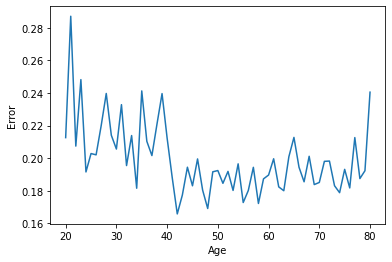

In [111]:
fig, ax = plt.subplots()
ax.set_xlabel("Age")
ax.set_ylabel("Error")
# plt.ylim(ymax = 0.5)
ax.plot(age_to_consider, np.array(error_data[0]).T)
plt.show()

In [115]:
pd.DataFrame(error_data, columns=femalet, index=age_to_consider).to_csv("female_error_table.csv", float_format="%.4f")

In [112]:
error_data = np.array(error_data)

In [113]:
np.save("error_data.npy", error_data)

In [114]:
error_data = np.load("error_data.npy", allow_pickle=True)
error_data = error_data.T

In [51]:
maxs = error_data.max(1)
maxs.mean()

0.15548770254521851

In [52]:
stds = error_data.std(1)
stds.mean()

0.03706927782179127

In [53]:
means = error_data.mean(1)
means.mean()

0.0857817828387461

In [54]:
mins = error_data.min(1)
mins.mean()

0.050733373785191126

In [55]:
pd.set_option('display.max_rows', 500)

In [56]:
data = pd.DataFrame(np.array((mins, maxs, stds, means)).T, columns=["Min", "Max", "Std", "Avg"], index=age_to_consider)

In [57]:
data

,Min,Max,Std,Avg
20,0.065890,0.161673,0.032250,0.092955
21,0.045389,0.203901,0.054949,0.102301
22,0.052286,0.187223,0.047942,0.095756
23,0.056077,0.201691,0.052922,0.105502
24,0.057823,0.175859,0.041528,0.094917
25,0.051033,0.158371,0.038761,0.081457
26,0.054977,0.181209,0.044520,0.094307
27,0.049680,0.148027,0.034888,0.084045
28,0.060385,0.166586,0.037442,0.090573
29,0.055142,0.142448,0.029763,0.082659


In [58]:
data["Avg"].std()

0.010062244524413698

In [59]:
data["Avg"].idxmin()

49

In [60]:
data.loc[49]

Min    0.046254
Max    0.114961
Std    0.027388
Avg    0.067885
Name: 49, dtype: float64

<AxesSubplot:ylabel='Error'>

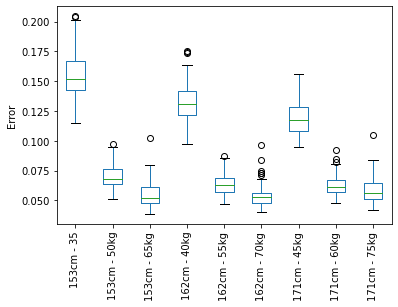

In [61]:
data_temp = pd.DataFrame(error_data, columns=femalet, index=age_to_consider)
data_temp.plot(kind="box", rot=90, ylabel="Error")